# ICPE Data Challenge 2024

This notebook contains analyses of the Globus dataset with the aim to analyze what proportion of tasks submitted on the platform are not latency-sensitive: that is, they are delayable.

Our findings here can further support the idea of delaying tasks in serverless architectures to improve latency and throughput of latency-sensitive tasks, and also result in fewer resource usage and cost for the users of the platform.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [2]:
sns.set_style('whitegrid')

In [3]:
tasks = pd.read_csv("../datasets/GlobusComputeDataset-v1-tasks.csv")

In [4]:
tasks = tasks.dropna(subset=['received', 'result_received'])

In [5]:
functions = pd.read_csv("../datasets/GlobusComputeDataset-v1-functions.csv")

## Analyzing task latencies

In [6]:
task_latencies = pd.DataFrame({"Task latency (seconds)": (tasks["result_received"] - tasks["received"]) / 1000000000})

In [7]:
total_tasks = task_latencies.shape[0]

In [8]:
latencies_v = task_latencies['Task latency (seconds)']

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.histplot(
    data=task_latencies,
    bins=math.ceil(math.log2(total_tasks) + 1),
    log_scale=True
)

ax.get_legend().remove()

for rect in ax.patches:
    width, height = rect.get_width(), rect.get_height()
    x = rect.get_x()

    if height < 50000: continue
    
    bin_mask = (latencies_v >= x) & (latencies_v < x + width)
    bin_mean = latencies_v[bin_mask].mean().mean()
    
    plt.text(x + width/2., height, f"{bin_mean:.03}s", ha='center', va='bottom', rotation=45)

plt.ylabel('')
plt.xlabel('Task latencies from received to response received (seconds)')

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.histplot(
    data=task_latencies,
    bins=math.ceil(math.log2(total_tasks) + 1),
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False
)

ax.get_legend().remove()

mean_0_1 = latencies_v[(latencies_v <= 1) & (latencies_v >= 0)].mean()
mean_0_2 = latencies_v[(latencies_v > 1) & (latencies_v <= 5)].mean()
mean_0_3 = latencies_v[(latencies_v > 5) & (latencies_v <= 100)].mean()

plt.axvline(x=1, color='r', linestyle='--', label=f'Mean at [0, 1]')
plt.text(1.1, 0.3, f'{mean_0_1:.2f}s', ha="left", va="bottom")

plt.axvline(x=5, color='purple', linestyle='--', label=f'Mean at (1, 5]')
plt.text(6, 0.5, f'{mean_0_2:.2f}s', ha="left", va="bottom")

plt.axvline(x=100, color='g', linestyle='--', label=f'Mean at (5, 100]')
plt.text(120, 0.3, f'{mean_0_3:.2f}s', ha="left", va="bottom")

plt.legend()

plt.ylabel('CDF')
plt.xlabel('Task latencies from received to response received (seconds)')

In [11]:
less_than_1_second = latencies_v[latencies_v < 1]
more_than_1_second = latencies_v[latencies_v >= 1]
more_than_2_seconds = latencies_v[latencies_v >= 2]
more_than_5_seconds = latencies_v[latencies_v >= 5]

In [12]:
pct_less_1 = less_than_1_second.shape[0] / total_tasks
pct_more_1 = more_than_1_second.shape[0] / total_tasks
pct_more_2 = more_than_2_seconds.shape[0] / total_tasks
pct_more_5 = more_than_5_seconds.shape[0] / total_tasks

In [ ]:
plt.figure(figsize=(10, 10))

categories = pd.DataFrame({
    'Percentage': [pct_less_1, pct_more_1, pct_more_2, pct_more_5], 
    'Latency category': ['< 1 second', '>= 1 second', '>= 2 seconds', '>= 5 seconds']
})

bar_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']

sns.barplot(categories, x='Percentage', y='Latency category', hue='Latency category', alpha=.7, orient='y')

for index, row in categories.iterrows():
    pct = row['Percentage']
    plt.text(pct, index, f'{pct:.2}%', color='black', va="center")

plt.title('Percentage of Tasks in Different Latency Categories')
plt.xlabel('Latency Category')
plt.ylabel('Percentage')

## Same analysis on 3 thresholds

We are interested in the following numbers:

- 30s (HTTP timeout)
- 45 & 80 seconds (Cold starts paper)

We want to know what proportion of tasks submitted on the Globus platform present latencies higher than these times.

Text(0, 0.5, 'Percentage')

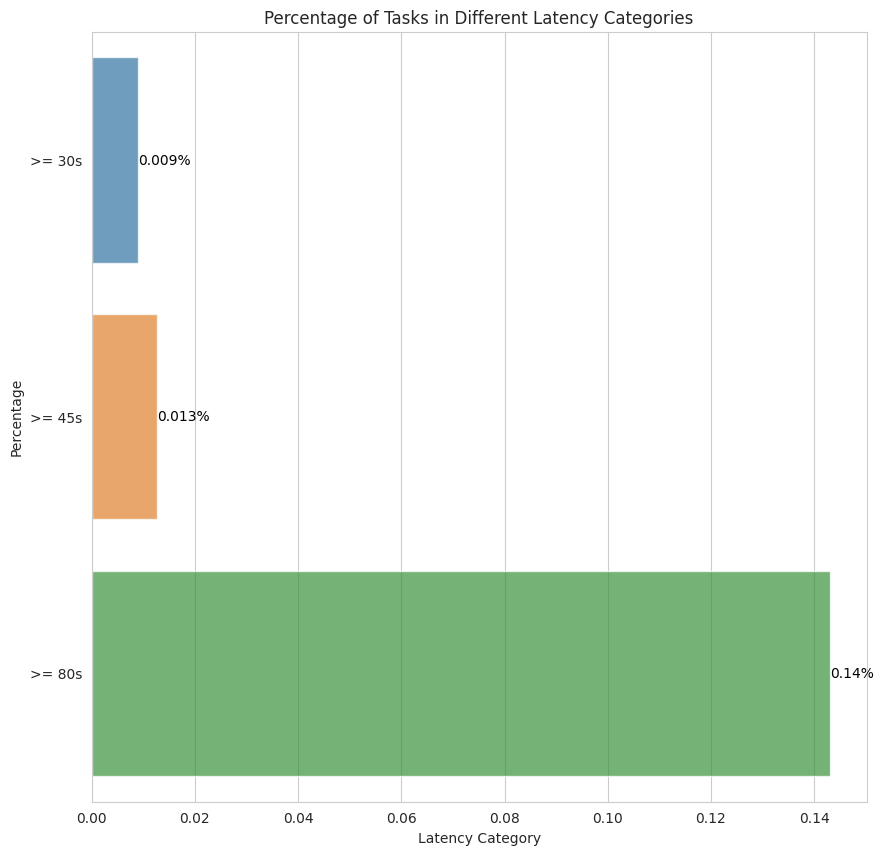

In [17]:
a = latencies_v[(latencies_v >= 30) & (latencies_v < 45)].shape[0] / total_tasks
b = latencies_v[(latencies_v >= 45) & (latencies_v < 80)].shape[0] / total_tasks
c = latencies_v[latencies_v >= 80].shape[0] / total_tasks

plt.figure(figsize=(10, 10))

categories = pd.DataFrame({
    'Percentage': [a, b, c], 
    'Latency category': ['>= 30s', '>= 45s', '>= 80s']
})

bar_colors = ['#FF6347', '#4682B4', '#32CD32']

sns.barplot(categories, x='Percentage', y='Latency category', hue='Latency category', alpha=.7, orient='y')

for index, row in categories.iterrows():
    pct = row['Percentage']
    plt.text(pct, index, f'{pct:.2}%', color='black', va="center")

plt.title('Percentage of Tasks in Different Latency Categories')
plt.xlabel('Latency Category')
plt.ylabel('Percentage')

## Analyzing task function categories

In [14]:
functions

,function_uuid,function_body_uuid,loc,cyc_complexity,num_of_imports
0,6f761b2f-b776-b1e2-ddeb-9ec002e484e4,1cd2079c-72a4-089e-9652-2ca5f5f9ec42,54.0,10.0,1.0
1,fef43cc0-a26a-b13f-e956-3455b3d24a41,1627f3ca-0405-4404-4dbc-bd387425aa38,3.0,1.0,0.0
2,fdecf895-cfa5-a1e8-569e-f631c60965e2,1cd2079c-72a4-089e-9652-2ca5f5f9ec42,54.0,10.0,1.0
3,cacfa841-7210-e4e8-6508-5c025381a5bd,1cd2079c-72a4-089e-9652-2ca5f5f9ec42,54.0,10.0,1.0
4,14babd79-1054-93e1-c559-713fda85fb20,44c9883f-b632-30cd-2a0e-999ff52f40c5,NaN,NaN,NaN
...,...,...,...,...,...
277381,cb97304f-5dff-e934-44d8-42144263ee2c,7502ac21-fb80-6404-5e59-7977d4b5ef7f,5.0,1.0,2.0
277382,c00910a2-0320-d35d-35c7-d3776d6b3dee,157d4850-88b8-a2bd-0914-b055d6c245fd,18.0,4.0,3.0
277383,694daf13-bf49-7aff-4d2d-0bc5e62a798a,9047fa88-a231-8867-17d1-38b787d18751,15.0,3.0,2.0
277384,5ceca064-e135-1a1f-c0e4-9ea9dab4fbd4,147e2ff0-73cb-e11d-3720-7d7a10f45f12,49.0,5.0,4.0
